<center><h1> Lab05 102062207 Regressor</h1></center>



# General Description
This notebook will be divided into 3 parts, each part will be corresponded to one of the three question given in the this assigment, and each part will also be broke into several subsection in order to clarify my code and thoughts. 

Now, we will walk through the whole assignment in the following order:
* Implementation of LassoRegressor
* Tune & Train the LassoRegressor
* Feature Selection and XRegressor

# Part I. Implementation of LassoRegressor

The LassoRegressor is a type of regressor that deal with the regression problem by solving the cost function:
$$\arg\min_{\boldsymbol{w}\in\mathbb{R}^{D},b}\frac{1}{2N}\Vert\boldsymbol{y}-(\boldsymbol{X}\boldsymbol{w}-b\boldsymbol{1})\Vert^{2}+\alpha\Vert\boldsymbol{w}\Vert_{1},$$
 
Where $\alpha$ is a constant that will determine how much the **1-norm** term will influence the cost function, and the term $N$ is the number of samples that used to train the regressor.

To lower the result of the cost function above, one frequently used method is **gradient descent**:
$$x^{(t+1)}=x^{(t)}-\eta g$$
Where t is the t-th iteration, $\eta$ is learning rate, or stepsize, and $g$ is the gradient. By solving this equation iteratively, we can reach a **local optimum point** with a proper **stepsize**.


Since we need to compute gradient, we have to apply **partial differentiation** to the cost function. However, one may found that is that the **1-norm** term might be **non-differentiable** at some points. This phenomenon will cause a big problem when we are training the regressor because that we want to use gradient descent method to train, but **we cannot obtain a gradient from a non-differentiable point.**

To cope with that annoying non-differentialble problem, I choose **subgradient method** as a method to tackle the problem.

#### Subgradient Method
The idea of subgradient method is simple :
* When the point is differentialble, we just simply compute the gradient
* If it's not differentiable, we randomly assign a value $[-1, 1]$ to it, as a **subgradient** and use it to do the descent task.

However, a **negative subgradient may to point to a descent direction.** Some constraint have to be imposed on it to make sure that our algorithm will descent.

Thus, I impose the following constraint to the subgradient:
$$\eta=\frac{f(x_k) - f^{lev}_{k}}{\Vert s_k\Vert ^2}$$

Where $\eta$ is a **modified** learning rate, $s_k$ is a subgradient, $f(x_k)$ is the cost function at iteration $k$, and $f^{lev}_{k}=\min_{0\leq i\leq k}f(x_{i})$.

This constraint can be simply interpreted as the description below:
* If the regressor is converged to some point, the  $\eta$ will be closed or equal to $0$.
  - that is, when the regressor is closed to some local optimum points, it shouldn't take a big step size. This can prevent it from leaving the local optimum point since it has limited effect on the descent direction .
* If the regressor is far from some points with low cost, the $\eta$ will increase.
  - that is, since you are not closed to any local optimum, you can take a big step.
  
By applying this constraint, we can make sure that the non-differential point won't drag the descent direction away from local optimum point, and thus the whole process will descent.

In [1]:
%matplotlib inline

#### Implementation

Now let's take a look at my implementation.
The comments in the code below will explain the details of my implementation.

In [2]:
from pylab import *
from copy import deepcopy

In [3]:
class LassoRegressor(object):
    
    def __init__(self, eta=0.001, alpha=0.001, n_iter=40, random_state=1, zero=1e-10):
        """ Initialize LassoRegressor.
        
        Parameters
        ----------
        eta : float
              Learing rate.
        alpha : float
              The coefficient of the 1-norm term in the cost function
        n_iter : int
              Numbers of iteration.
        random_state : int
              Random seed.
        zero : float
              Value that smaller than zero will be considered as zero.
        """
        self.eta = eta
        self.alpha = alpha
        self.n_iter = n_iter
        self.zero = zero
        self.random_state = random_state
        
    def fit(self, X, y, stop_crit=1e+15):
        """ Fit the model with given traning set.
        
        Parameters
        ----------
        X : ndarray
            Training data.
        y : ndarray
            Label of training data.
        stop_crit : float
            If the result of cost function exceeds this value,
            the training process will be stop since it cannot
            converge.
        
        Returns
        -------
        self :
               Trained model.
        """
        
        # First, we initialize the weights with random value.
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1+X.shape[1])
        self.cost_ = []
        N = X.shape[0]
        

        # After initializing the weights, we start iterating to
        # solve the cost function. The self.w_[0] indicates the
        # intercept/bias of the function, so we don't need to 
        # do gradient descent on it.
        for i in range(self.n_iter):
            output = self.predict(X)
            # this term is equal to :
            # y - (Xw - b1)
            errors = (y - output)
            L1_norm = np.fabs(self.w_[1:]).sum()
            
            # calculate the "SSE" term.
            # This is equal to the gradient of
            # (1/2N)||y - (Wx - b1)||^2
            SSE = self.eta * X.T.dot(errors) / N

            # subgradient_descent_ will help us get
            # the gradient of a||w||_1.
            # You can see the detailed explanation in
            # its function defintion.
            L1_sub = self.subgradient_descent_()
            
            # update weights.
            # the reason why 'SSE' we add SSE to weights instead
            # of subtracting is that the partial derivative term
            # will have a negative sign. So the updating rule:
            # x(t+1) = x(t) - g(x) = x(t) - (-eta*(y-(Wx-b)))
            #        = x(t) + (eta*(y-(Wx-b)))
            # and the term 'L1_sub' do not have a negative sign,
            # so it's still a subtrahend.
            self.w_[1:] += SSE - L1_sub
            
            # update bias by simply adding the errors to i.
            self.w_[0] += self.eta * errors.sum()
            
            # update the cost 
            cost = (errors**2).sum() / (2.0 * N) + self.alpha * L1_norm
            self.cost_.append(cost)
        
            # stop if the errors exceed stop criteria.
            if errors.sum() > stop_crit:
                print("Error! Sum of errors exceeds stop criteria")
                break
        return self
    
    def subgradient_descent_(self):
        """ Computing the gradient for the differential point in 1-norm
            as well as the subgradient for the non-differetiable point.
        """
        # the derivative of 1-norm will be 1 or -1 according
        # to its sign. 
        # (ex. -5 will have a derivative 1, while 0.5 will have 1.)
        subgrad = np.sign(self.w_[1:])
        n_eta = deepcopy(self.eta)
        
        # The 1-norm is non-differetiable when the value is equal
        # to 0. Find this point by using np. operation
        non_diff = (np.fabs(self.w_[1:]) <= self.zero)
        can_diff = np.logical_not(non_diff)

        if len(non_diff[non_diff == True]) > 0:
            
            subgrad[non_diff] = np.random.uniform(-1, 1)
            
            # apply the constraint to it.
            # but we have to make sure we already have costs first.
            if len(self.cost_) > 0:
                
                # get f(x_k), and find the minimum cost in the previous
                # cost results.
                cost = self.cost_[-1]
                min_cost = min(self.cost_)
                
                # adjust the learning rate.
                # if the current cost is equal to the minimum one,
                # then the subgradient won't influence the descent direction;
                # otherwise, it will change the direction and stepsize based
                # on the difference between cost and min_cost.
                n_eta = (cost - min_cost) / ((np.fabs(subgrad).sum())**2)
                
        # apply different learning rate to gradient and subgradient
        subgrad[non_diff] *= n_eta
        subgrad[can_diff] *= self.eta
        
        # multiply alpha
        subgrad *= self.alpha

        return subgrad
    
    def predict(self, X):
        """ Predict the regression result of X by solving
            y = w0 + w0x0 + w1x1 ... + wnxn
        """
        return np.dot(X, self.w_[1:]) + self.w_[0]

Now, we need to make sure that our LassoRegressor can have the **tendency of convergence**.

We test it by using small $\eta$ and $\alpha$, and a very small iterations number:

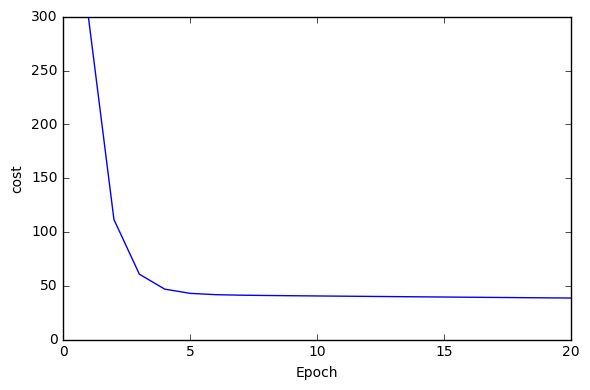

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso


train_set = np.loadtxt('X_train.csv', delimiter=',')
y_train = np.loadtxt('y_train.csv', delimiter=',')

sc_x = StandardScaler()
X_std = sc_x.fit_transform(train_set)
#y_train_std = sc_y.fit_transform(y_train)

llr = LassoRegressor(eta=0.001,alpha=0.001, n_iter=20)
llr = llr.fit(X_std, y_train)


plt.plot(range(1, llr.n_iter+1), llr.cost_)
plt.ylabel('cost')
plt.xlabel('Epoch')
plt.tight_layout()
plt.savefig('./output/fig-lasso-cost.png', dpi=300)
plt.show()

The figure above shows that our regressor does regress in only just 5 iterations!
So why do I choose small $\eta$ and $\alpha$ ?

Since we want to verify our implementation, we need to make sure it can work properly, that is, it can converge in finite iterations. However, some other factors may also let regressor be unable to converge:
* Overshooting, which happens when the stepsize($\eta$) is too big
* The regressor cannot find a set of $w$ to solve the problem

When we choose a $\alpha$ too big, the coefficients of each features will be pressed to zero, and thus resulting large errors. So, to verify our implementation, we have to rule out these two situations by selecting small $\eta$ and $\alpha$, and thus we can identify the problem of our LassoRegressor more easily.


Now, let's try it with more iterations:

In [5]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

llr = LassoRegressor(eta=0.001,alpha=0.001, n_iter=500)
llr = llr.fit(X_std, y_train)

y_train_pred = llr.predict(X_std)

print('MSE train: %.2f' % (mean_squared_error(y_train, y_train_pred)))
print('R^2 train: %.2f' % (r2_score(y_train, y_train_pred)))


MSE train: 33.75
R^2 train: 0.61


By examining the $R^2$ and $MSE$, we can see the regressor works fine.

Knowing that our LassoRegressor is usable, we can begin our task 2: **Tune & Train the LassoRegressor**.

# Part II. Tune & Train the LassoRegressor

In [6]:
import seaborn as sns
import pandas as pd

/home/atsu/anaconda3/envs/ML_ENV/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


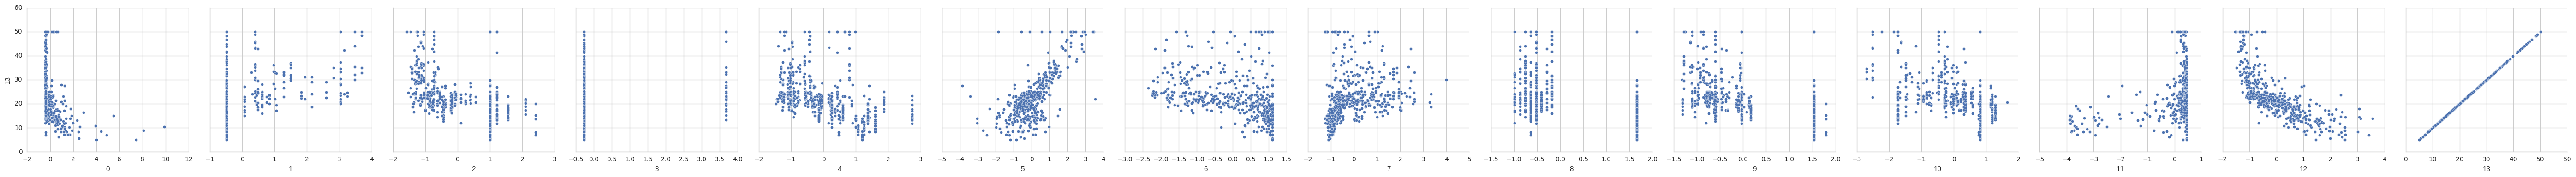

In [7]:
data = np.concatenate([X_std, y_train.reshape(-1, 1)], axis=1)
df = pd.DataFrame(data)
sns.set(style='whitegrid', context='notebook')
sns.pairplot(df, x_vars=df.columns[0:X_std.shape[0]], y_vars=df.columns[-1], size=4)
plt.tight_layout()
plt.savefig('./output/fig-housing-pairwise-dist.png', dpi=300)
plt.show()
sns.reset_orig()


Now, prints out the weight $w\_$, to see how each feature contributes to the prediction.

By observing the weights and the figure we plotted above, it's obvious that some useless features still has a very high weights.
We can still apply PCA to do feature extraction.
By examining the explained variance ratio, we can find that some of the features are useless.

In [8]:
from sklearn.cross_validation import train_test_split

a = 0.001
eta = 0.001
max_iter = 5000
alphas = [0.001, 0.01, 0.1, 1]
max_comps = 13

candidates = []
r2_lists = []
mse_lists = []
a_lists = []

for a in alphas:
    print("running with init alpha : %.3f" % (a))

    a_list = []
    r2_list = []
    mse_list = []
    inc = a
    for i in range(0, 10):

        X_tune_train, X_val, y_tune_train, y_val = train_test_split(
        X_std, y_train, test_size=0.4, random_state=1)

        llr = LassoRegressor(eta=eta, alpha=a, n_iter=max_iter)
        llr = llr.fit(X_tune_train, y_tune_train)
        
        y_val_pred = llr.predict(X_val)
        r2  = r2_score(y_val, y_val_pred)        
        mse = mean_squared_error(y_val, y_val_pred)
        
        a_list.append(a)
        r2_list.append(r2)
        mse_list.append(mse)
    
        a += inc
    a_lists.append(a_list)
    r2_lists.append(r2_list)
    mse_lists.append(mse_list)
    
print('Finished searching alpha')

/home/atsu/anaconda3/envs/ML_ENV/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


running with init alpha : 0.001
running with init alpha : 0.010
running with init alpha : 0.100
running with init alpha : 1.000
Finished searching alpha


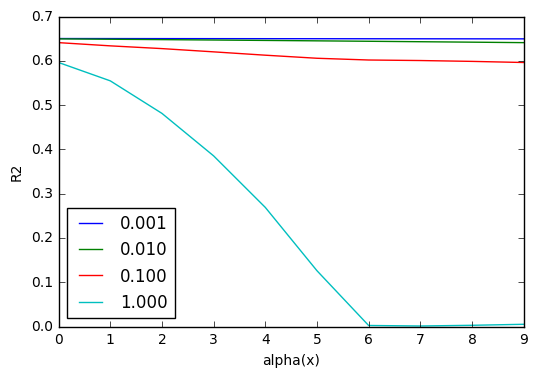

In [9]:
a = 0.001
for l in r2_lists:
    a_alpha = "%.3f" % a
    plt.plot(range(0,10), l, label=a_alpha)
    a *= 10

plt.ylabel('R2')
plt.xlabel('alpha(x)')
plt.legend(loc='best')
plt.savefig('./output/fig-alpha-plot-r2', dpi=300)
plt.show()

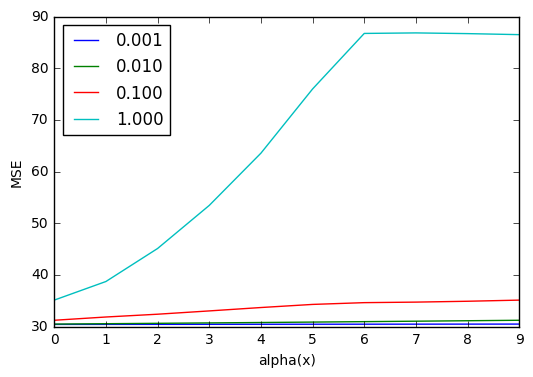

In [10]:
a = 0.001
for l in mse_lists:
    a_alpha = "%.3f" % a
    plt.plot(range(0,10), l, label=a_alpha)
    a *= 10

plt.ylabel('MSE')
plt.xlabel('alpha(x)')
plt.legend(loc='best')
plt.savefig('./output/fig-alpha-plot-mse', dpi=300)
plt.show()

In [11]:
from sklearn.linear_model import LinearRegression

X_test = np.loadtxt('X_test.csv', delimiter=',')
y_test = np.loadtxt('y_test.csv', delimiter=',')

X_test = sc_x.transform(X_test)

olr = LinearRegression()
olr = olr.fit(X_std, y_train)

llr = LassoRegressor(alpha=0.001, n_iter=max_iter)
llr = llr.fit(X_std, y_train)

y_train_pred_o = olr.predict(X_std)
y_test_pred_o = olr.predict(X_test)

y_train_pred = llr.predict(X_std)
y_test_pred = llr.predict(X_test)


print("Ordinary least sequare regressor")
print(" R2 train: %.2f, test: %.2f" %(
        r2_score(y_train, y_train_pred_o), 
        r2_score(y_test, y_test_pred_o))
     )
print("MSE train: %.2f, test: %.2f" %(
        mean_squared_error(y_train, y_train_pred_o), 
        mean_squared_error(y_test, y_test_pred_o))   
    )

print("\nMy LassoRegressor")
print(" R2 train: %.2f, test: %.2f" %(
        r2_score(y_train, y_train_pred), 
        r2_score(y_test, y_test_pred))
     )
print("MSE train: %.2f, test: %.2f" %(
        mean_squared_error(y_train, y_train_pred), 
        mean_squared_error(y_test, y_test_pred))    
    )


Ordinary least sequare regressor
 R2 train: 0.74, test: 0.73
MSE train: 22.25, test: 15.81

My LassoRegressor
 R2 train: 0.73, test: 0.75
MSE train: 23.08, test: 14.84


In [12]:
def plot_compress(coef, max_alpha):
    plt.hlines(y=0, xmin=0, xmax=max_alpha, color='red', linewidth = 2, linestyle = '--')

    for i in range(coef.shape[1]):
        plt.plot(range(max_alpha),coef[:,i])
    
    plt.ylabel('Coefficients')
    plt.xlabel('Alpha')
    plt.tight_layout()
    plt.savefig('./output/fig-lasso-decay.png', dpi=300)
    plt.show()


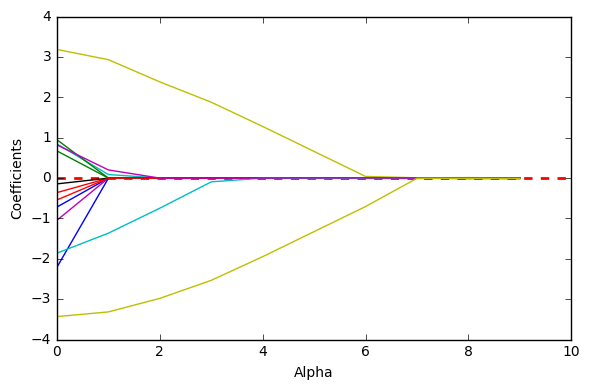

In [13]:
max_alpha = 10
coef = np.zeros((max_alpha, X_std.shape[1]))

for a in range(max_alpha):
    llr = LassoRegressor(alpha=a, n_iter=max_iter)
    llr.fit(X_std, y_train)
    coef[a,:] = llr.w_[1:].reshape(1, -1)
    
plot_compress(coef, max_alpha)

# Part III. Feature Selecetion and XRegressor

Since Lasso can be a feature selector, we can use it to see what each feature has contribute to the prediction by examining the weights(coefficients) of our LassoRegresor.

Now, let's check.

Feature #6 : 0.18538
Feature #13 : -0.18139
Feature #11 : -0.11826
Feature #3 : -0.09587
Feature #5 : -0.08630
Feature #10 : -0.07531
Feature #1 : -0.05629
Feature #7 : -0.05295
Feature #9 : -0.04917
Feature #2 : 0.04856
Feature #12 : 0.03804
Feature #8 : 0.00329
Feature #4 : 0.00144


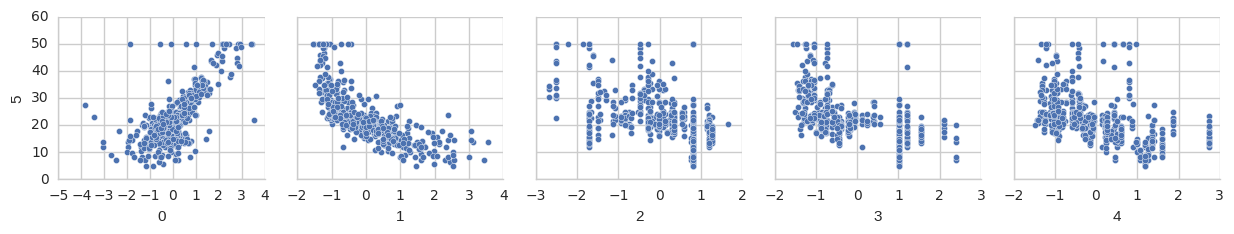

In [14]:
llr = LassoRegressor(alpha=2)
llr = llr.fit(X_std, y_train)
feat = np.argsort(np.fabs(llr.w_[1:]))[::-1]

for i in range(len(llr.w_[1:])):
    print("Feature #%d : %.5f" %(feat[i]+1, llr.w_[feat[i]+1]))

n_sel = 5
selected = feat[0:n_sel]
selected_data = np.concatenate([X_std[:, selected], y_train.reshape(-1, 1)], axis=1)
df = pd.DataFrame(selected_data)
sns.set(style='whitegrid', context='notebook')
sns.pairplot(df, x_vars=df.columns[0:n_sel], y_vars=df.columns[-1], size=2.5)
plt.tight_layout()
plt.savefig('./output/fig-feat-pairwise-dist.png', dpi=300)
plt.show()
sns.reset_orig()


In [15]:
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression

class XRegressor(object):
    """
        A lasso regressor that uses coordinate descent as a descent method
    """
    def __init__(self, alpha=0.001, n_iter=40, random_state=1, zero=1e-10):
        self.eta = eta
        self.alpha = alpha
        self.n_iter = n_iter
        self.zero = zero
        self.random_state = random_state
        
    def fit(self, X, y, n_e_iter=3000, n_alpha=2, n_feat=5, 
                        extract_feats=False, remove_outlier=False, ro_thresh=4.0, stop_crit=1e+15):
        
        if extract_feats:
            X = self.extract_feats_(X, y, alpha=n_alpha, n_iter=n_e_iter, n_feat=n_feat)
        
        if remove_outlier:
            X, y = self.ransac_feats_(X, y, ro_thresh)
        
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1+X.shape[1])
        self.cost_ = []
        N = X.shape[0]
        norm_X = (X**2).sum(axis=0)
        
        # notes that self.w_[0] is the intercept term
        # The concept of Coordinate Descent is that we find min of x_j
        # "ONE AT A TIME." Doing it simultaneously won't work at all.
        # and since Coordinate descent is "derivative free", we need no
        # gradient this time!
        
        for i in range(self.n_iter):
            for j in range(1, len(self.w_)):
                # We need to compute each x_j independently, so we should
                # first set the "influence" of x_j to zero.
                r_resp = self.predict(X, ignore=j)
                # partial residual
                pr = y - r_resp
                # residual predictor
                r_pred = X[:, j-1].dot(pr).sum()
                self.w_[j] = self.soft_threshold_(r_pred, N) / norm_X[j-1]
            output = self.predict(X)
            errors = y - output

            L1_norm = np.abs(self.w_[1:]).sum()
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / (2.0 * N) + self.alpha * L1_norm
            self.cost_.append(cost)
            
            
            if errors.sum() >= stop_crit:
                print("Error! Sum of errors exceeds stop criteria")
                break
        
        return self
    
    def soft_threshold_(self, r_pred, N):
        if np.fabs(r_pred) < (self.alpha * N):
            return 0
        return np.sign(r_pred) * (np.fabs(r_pred) - (self.alpha * N))
    
    def extract_feats_(self, X, y, alpha, n_iter, n_feat):
        llr = LassoRegressor(alpha=alpha, n_iter=n_iter)
        llr = llr.fit(X, y)
        feat = np.argsort(np.fabs(llr.w_[1:]))[::-1]
        self.selected = feat[0:n_feat]
        
        return X[:, self.selected]
    
    def ransac_feats_(self, X, y, thresh):
        ransac = RANSACRegressor(LinearRegression(), 
                max_trials=100, 
                min_samples=50, 
                residual_threshold=thresh, 
                random_state=0)
        ransac.fit(X, y)
                   
        inlier = ransac.inlier_mask_
        X_filt = X[inlier, :]
        y_filt = y[inlier]
        return X_filt, y_filt
    
    def predict(self, X, ignore=None):
        # for x^0 to x^n 
        if ignore == None:
            return np.dot(X, self.w_[1:]) + self.w_[0]
        
        ign_ = deepcopy(self.w_[1:])
        ign_[ignore-1] = 0
        
        return np.dot(X, ign_) + self.w_[0]
    

In [16]:
def r2_bar_score(y, y_pred, N, P):
    return 1 - ((((y - y_pred)**2).sum()) / (N - P - 1)) / ((((y - np.mean(y))**2).sum()) / (N - 1))


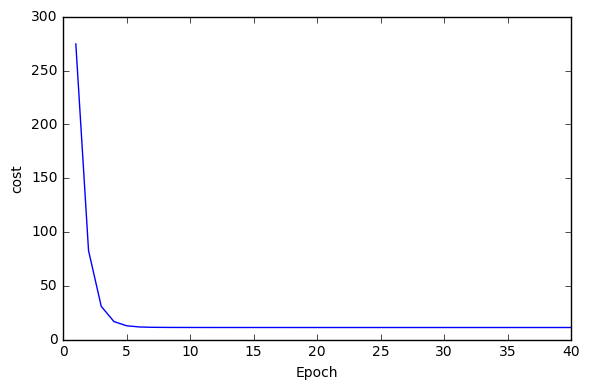

MSE train: 22.25
R^2 train: 0.74


In [17]:
train_set = np.loadtxt('X_train.csv', delimiter=',')
y_train = np.loadtxt('y_train.csv', delimiter=',')

sc_x = StandardScaler()
X_std = sc_x.fit_transform(train_set)

xr = XRegressor()
xr = xr.fit(X_std, y_train, extract_feats=False)

plt.plot(range(1, xr.n_iter+1), xr.cost_)
plt.ylabel('cost')
plt.xlabel('Epoch')
plt.tight_layout()
plt.savefig('./output/fig-lasso-cost.png', dpi=300)
plt.show()

y_train_pred = xr.predict(X_std)
print('MSE train: %.2f' % (mean_squared_error(y_train, y_train_pred)))
print('R^2 train: %.2f' % (r2_score(y_train, y_train_pred)))


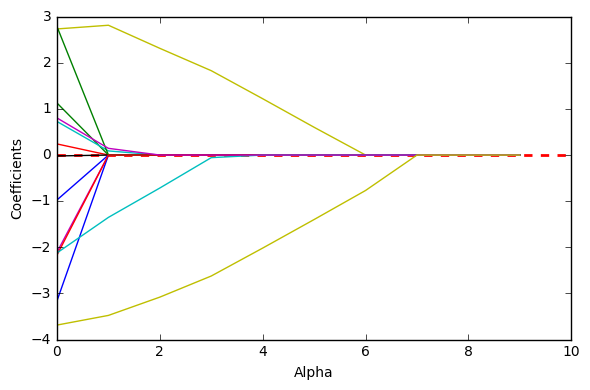

In [18]:
max_alpha = 10
coef = np.zeros((max_alpha, X_std.shape[1]))

for a in range(max_alpha):
    xr = XRegressor(alpha=a, n_iter=max_iter)
    xr.fit(X_std, y_train)
    coef[a,:] = xr.w_[1:].reshape(1, -1)
    
plot_compress(coef, max_alpha)

In [19]:
def print_train_val(y_train_pred, y_train, y_valid_pred, y_valid, train_size, valid_size, P):
    print("      Training R2_bar: %.2f, R2: %.2f, MSE: %.2f" % (
        r2_bar_score(y_train, y_train_pred, train_size, P),
        r2_score(y_train, y_train_pred),
        mean_squared_error(y_train, y_train_pred)
    ))
    
    print("    Validating R2_bar: %.2f, R2: %.2f, MSE: %.2f" % (
        r2_bar_score(y_valid, y_valid_pred, valid_size, P),
        r2_score(y_valid, y_valid_pred),
        mean_squared_error(y_valid, y_valid_pred)
    ))


In [20]:
train_set = np.loadtxt('X_train.csv', delimiter=',')
y_train = np.loadtxt('y_train.csv', delimiter=',')
X_std = sc_x.fit_transform(train_set)

max_feats = 5
mse_best = 100
r2b_best = 0
for i in range(1, max_feats+1):
    sc_x = StandardScaler()

    X_tune_train, X_valid, y_tune_train, y_valid = train_test_split(
        X_std, y_train, test_size=0.5, random_state=0)
    
    xr = XRegressor(alpha=0.001, n_iter=max_iter)
    xr = xr.fit(X_tune_train, y_tune_train, n_feat=i, extract_feats=True)

    y_train_pred = xr.predict(X_tune_train[:, xr.selected])
    y_valid_pred = xr.predict(X_valid[:, xr.selected])
    print("=== %d features ===" %(i))
    print("Selected : %s" %(xr.selected))
    print("Coordinate Descent")
    print_train_val(y_train_pred, y_tune_train, y_valid_pred, y_valid,
                    X_tune_train.shape[0], X_valid.shape[0], xr.w_.shape[0]-1)

    
    llr = LassoRegressor(alpha=0.001, n_iter=max_iter)
    llr = llr.fit(X_tune_train[:, xr.selected], y_tune_train)

    y_train_pred = llr.predict(X_tune_train[:, xr.selected])
    y_valid_pred = llr.predict(X_valid[:, xr.selected])
    
    print("Subgradient Descent")
    print_train_val(y_train_pred, y_tune_train, y_valid_pred, y_valid,
                    X_tune_train.shape[0], X_valid.shape[0], llr.w_.shape[0]-1)

    
    

=== 1 features ===
Selected : [12]
Coordinate Descent
      Training R2_bar: 0.53, R2: 0.53, MSE: 40.79
    Validating R2_bar: 0.54, R2: 0.54, MSE: 38.71
Subgradient Descent
      Training R2_bar: 0.53, R2: 0.53, MSE: 40.79
    Validating R2_bar: 0.54, R2: 0.54, MSE: 38.74
=== 2 features ===
Selected : [12  5]
Coordinate Descent
      Training R2_bar: 0.60, R2: 0.60, MSE: 34.70
    Validating R2_bar: 0.66, R2: 0.66, MSE: 28.31
Subgradient Descent
      Training R2_bar: 0.60, R2: 0.60, MSE: 34.71
    Validating R2_bar: 0.66, R2: 0.66, MSE: 28.19
=== 3 features ===
Selected : [12  5 10]
Coordinate Descent
      Training R2_bar: 0.63, R2: 0.64, MSE: 31.67
    Validating R2_bar: 0.70, R2: 0.71, MSE: 24.62
Subgradient Descent
      Training R2_bar: 0.63, R2: 0.64, MSE: 31.68
    Validating R2_bar: 0.70, R2: 0.71, MSE: 24.51
=== 4 features ===
Selected : [12  5 10  0]
Coordinate Descent
      Training R2_bar: 0.64, R2: 0.65, MSE: 30.87
    Validating R2_bar: 0.70, R2: 0.70, MSE: 25.09
Subgra

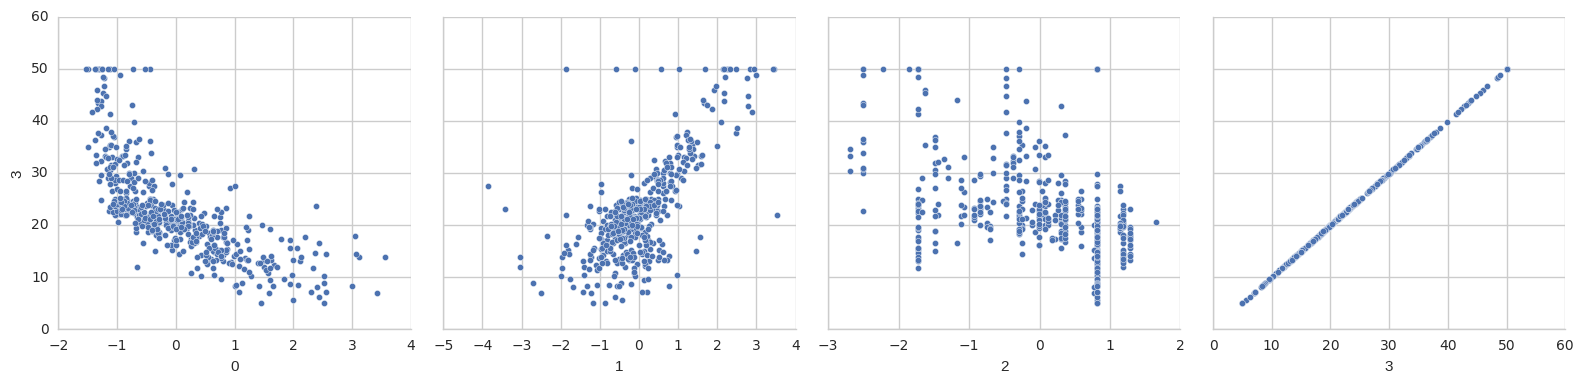

In [49]:

xr = XRegressor(alpha=0.001, n_iter=max_iter)
xr = xr.fit(X_std, y_train, n_feat=3, extract_feats=True)

selected = xr.selected

data = np.concatenate([X_std[:, selected], y_train.reshape(-1, 1)], axis=1)
df = pd.DataFrame(data)
sns.set(style='whitegrid', context='notebook')
sns.pairplot(df, x_vars=df.columns[0:X_std[:,selected].shape[0]], y_vars=df.columns[-1], size=4)

plt.tight_layout()
plt.savefig('./output/fig-selected-3feats', dpi=300)
plt.show()
sns.reset_orig()




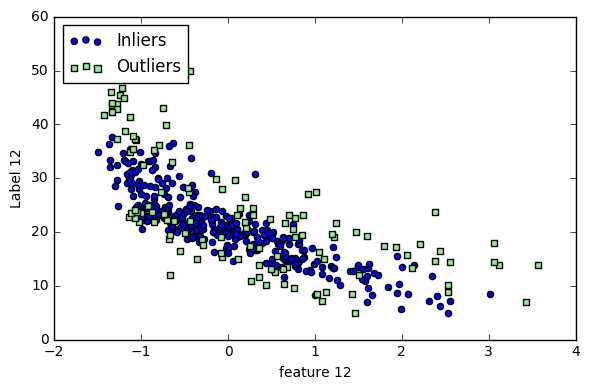

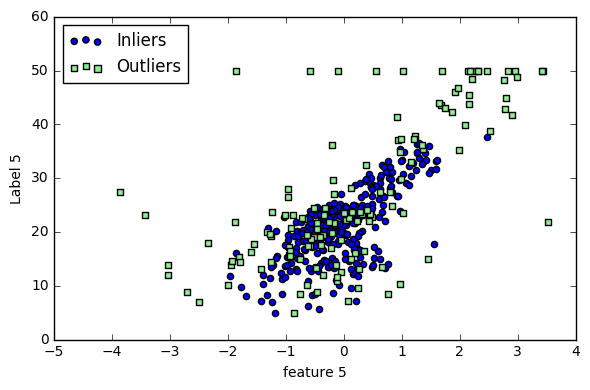

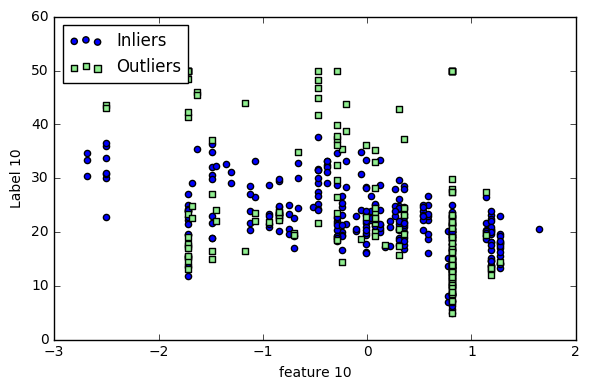

In [51]:
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression

ransac = RANSACRegressor(LinearRegression(), 
            max_trials=100, 
            min_samples=50, 
            residual_threshold=4.0, 
            random_state=0)

ransac.fit(X_std[:, selected], y_train)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
for i in selected:
    X_sel = X_std[:, [i]]
    line_X = np.arange(-4, 5, 1)
    #line_y_ransac = ransac.predict(line_X[:, np.newaxis])
    plt.scatter(X_sel[inlier_mask], y_train[inlier_mask], 
                c='blue', marker='o', label='Inliers')
    plt.scatter(X_sel[outlier_mask], y_train[outlier_mask],
                c='lightgreen', marker='s', label='Outliers')
    #plt.plot(line_X, line_y_ransac, color='red')
    plt.xlabel('feature %d' %(i))
    plt.ylabel('Label %d' %(i))
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()  


In [52]:
xr = XRegressor(alpha=0.001, n_iter=max_iter)
xr = xr.fit(X_std, y_train, n_feat=3, extract_feats=True, remove_outlier=True, ro_thresh=4.0)

y_test_pred = xr.predict(X_test[:, xr.selected])

print("XRegresso(filtered) Testing R2_bar: %.2f, R2: %.2f, MSE: %.2f" % (
    r2_bar_score(y_test, y_test_pred, X_test.shape[0], xr.w_.shape[0]-1),
    r2_score(y_test, y_test_pred),
    mean_squared_error(y_test, y_test_pred)
    ))



XRegresso(filtered) Testing R2_bar: 0.75, R2: 0.78, MSE: 13.00
